In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
# from astral.sun import sun
# from astral import LocationInfo
from skforecast.datasets import fetch_dataset
import seaborn as sns

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

# Modelling and Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
# import shap

c:\Users\chwen\anaconda3\envs\forecast_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
# Data download
# ==============================================================================
data = fetch_dataset(name='vic_electricity', raw=True)
data.info()

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [4]:
data

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


In [5]:
# Data preparation
# ==============================================================================
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data.head(2)

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True


In [6]:

# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.

df = data.drop(columns=["Date","Holiday"])
df = (
    df
    .resample(rule="H", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
    })
)

df_demand = df.Demand.resample('Y').agg(['mean','median'])

C:\Users\chwen\AppData\Local\Temp\ipykernel_29928\1262957033.py:7: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\chwen\AppData\Local\Temp\ipykernel_29928\1262957033.py:15: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



In [7]:
# df_t = df.copy()
# df_t = df_t.resample('15min').asfreq()
# df_t['Demand'] = df_t['Demand'].ffill()
# df_t

In [8]:
'''
this is possible because earlier you have set:
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%dT%H:%M:%SZ')
df = df.set_index('Time')  <---!!!!
'''

df['hour']=df.index.hour
df['dayofweek']=df.index.dayofweek
df['month']=df.index.month
df['quarter']=df.index.quarter
df['year']=df.index.year
df['dayofyear']=df.index.dayofyear
df.head(5)

,Demand,Temperature,hour,dayofweek,month,quarter,year,dayofyear
Time,,,,,,,,
2011-12-31 14:00:00,4323.095350,21.225,14,5,12,4,2011,365
2011-12-31 15:00:00,3963.264688,20.625,15,5,12,4,2011,365
2011-12-31 16:00:00,3950.913495,20.325,16,5,12,4,2011,365
2011-12-31 17:00:00,3627.860675,19.850,17,5,12,4,2011,365
2011-12-31 18:00:00,3396.251676,19.025,18,5,12,4,2011,365


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'demand group by hour')

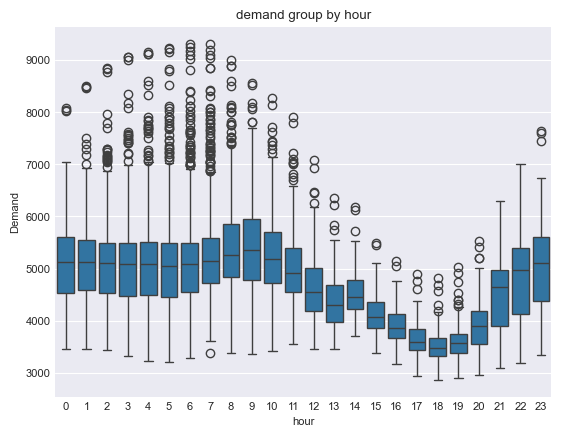

In [9]:

sns.boxplot(data=df,x='hour',y='Demand').set_title("demand group by hour") # data grouping by hour


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'demand group by month')

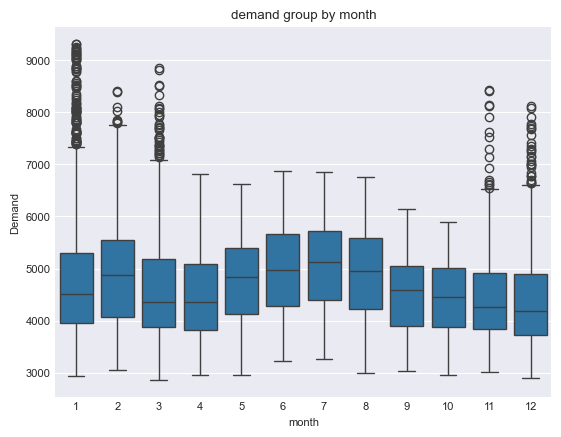

In [10]:
sns.boxplot(data=df,x='month',y='Demand').set_title("demand group by month") # data grouping by month


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'demand group by quarter')

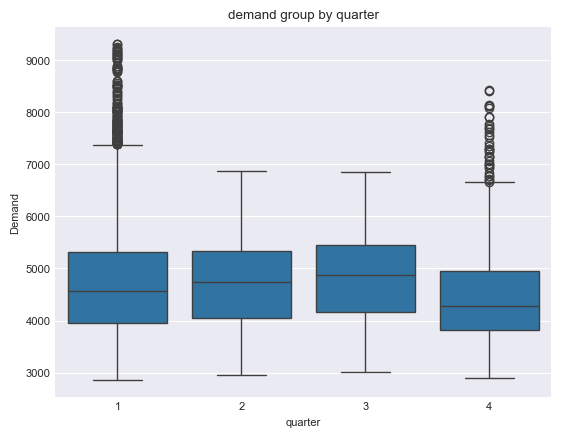

In [11]:
sns.boxplot(data=df,x='quarter',y='Demand').set_title("demand group by quarter") # data grouping by quarter